In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from dateutil.relativedelta import relativedelta
import geopandas as gpd 

%load_ext autoreload
%autoreload 2

### 1. Data import

#### 1.2 Read US shapefiles

<Axes: >

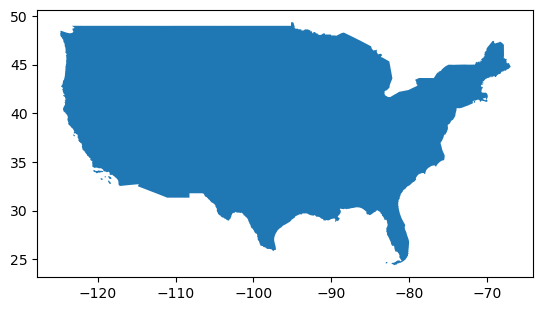

In [4]:
us_shape = gpd.read_file('tl_2018_us_county/tl_2018_us_county.shp').to_crs("EPSG:4326")

# filter continental US
us_continental_counties = us_shape.cx[-66:-125, 24:50].reset_index(drop=True)
us_continental_boundary = us_continental_counties.dissolve()
us_continental_boundary.plot()

#### 1.2 Read MODIS start dates

In [8]:
modis_dates = pd.read_excel("MODIS_dates.xlsx")
modis_dates = modis_dates.apply(lambda x: pd.to_datetime(x, format="%Y%m%d"))

modis_dates.iloc[6:9]

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
6,2003-02-18,2004-02-18,2005-02-18,2006-02-18,2007-02-18,2008-02-18,2009-02-18,2010-02-18,2011-02-18,2012-02-18,2013-02-18,2014-02-18,2015-02-18,2016-02-18,2017-02-18,2018-02-18,2019-02-18,2020-02-18,2021-02-18
7,2003-02-26,2004-02-26,2005-02-26,2006-02-26,2007-02-26,2008-02-26,2009-02-26,2010-02-26,2011-02-26,2012-02-26,2013-02-26,2014-02-26,2015-02-26,2016-02-26,2017-02-26,2018-02-26,2019-02-26,2020-02-26,2021-02-26
8,2003-03-06,2004-03-05,2005-03-06,2006-03-06,2007-03-06,2008-03-05,2009-03-06,2010-03-06,2011-03-06,2012-03-05,2013-03-06,2014-03-06,2015-03-06,2016-03-05,2017-03-06,2018-03-06,2019-03-06,2020-03-05,2021-03-06


#### 1.3 Read ECMWF seasonal forecasts

In [9]:
filtered_coords = pd.read_csv("filtered_coords_ecmwf.csv")
# read hindcasts
list_hindcasts = []
#for filename in ["apr_2003_09", "apr_2010_16", "apr_2017_23"]:
for filename in ["apr_2003_09"]:
    print("reading {}".format(filename))
    df = xr.open_dataset("data/" + filename.lower() + ".grib")
    print("ensembles mean")
    #df = df.mean("number")
    #df = df.to_dataframe().dropna().reset_index()
    print("filter coordinates to continental US")
    #df = df.merge(filtered_coords[["latitude", "longitude"]], on=["latitude", "longitude"], how="right")
    #list_hindcasts.append(df)

reading apr_2003_09
ensembles mean
filter coordinates to continental US


In [10]:
df

<xarray.Dataset>
Dimensions:     (number: 25, time: 7, step: 215, latitude: 25, longitude: 61)
Coordinates:
  * number      (number) int32 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
  * time        (time) datetime64[ns] 2003-04-01 2004-04-01 ... 2009-04-01
  * step        (step) timedelta64[ns] 1 days 2 days ... 214 days 215 days
    surface     float64 ...
  * latitude    (latitude) float64 49.0 48.0 47.0 46.0 ... 28.0 27.0 26.0 25.0
  * longitude   (longitude) float64 -125.0 -124.0 -123.0 ... -67.0 -66.0 -65.0
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    t2m         (number, time, step, latitude, longitude) float32 ...
    mx2t24      (number, time, step, latitude, longitude) float32 ...
    mn2t24      (number, time, step, latitude, longitude) float32 ...
    tp          (number, time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-05-30T10:46 GRIB to CDM+CF via cfgrib-0.9.1...

In [12]:
df.sel(latitude=[40], longitude=[-70]).to_dataframe()

surface valid_time         t2m  \
time       step     latitude longitude                                   
2003-04-01 1 days   40.0     -70.0          0.0 2003-04-02  280.386749   
           2 days   40.0     -70.0          0.0 2003-04-03  281.957764   
           3 days   40.0     -70.0          0.0 2003-04-04  281.012451   
           4 days   40.0     -70.0          0.0 2003-04-05  284.788116   
           5 days   40.0     -70.0          0.0 2003-04-06  284.017426   
...                                         ...        ...         ...   
2009-04-01 211 days 40.0     -70.0          0.0 2009-10-29  290.315826   
           212 days 40.0     -70.0          0.0 2009-10-30  289.154480   
           213 days 40.0     -70.0          0.0 2009-10-31  289.360962   
           214 days 40.0     -70.0          0.0 2009-11-01  290.088440   
           215 days 40.0     -70.0          0.0 2009-11-02  288.915100   

                                            mx2t24      mn2t24        tp  
time       step     latitude longitude                                    
2003-04-01 1 days   40.0     -70.0      280.327881  275.515808  0.001758  
           2 days   40.0     -70.0      283.628326  279.506470  0.004235  
           3 days   40.0     -70.0      284.415894  280.315247  0.004497  
           4 days   40.0     -70.0      285.577118  279.935913  0.006062  
           5 days   40.0     -70.0      287.278046  281.770538  0.008571  
...                                            ...         ...       ...  
2009-04-01 211 days 40.0     -70.0      291.651367  288.436646  0.922912  
           212 days 40.0     -70.0      291.396210  288.199768  0.927570  
           213 days 40.0     -70.0      290.882507  287.554810  0.931789  
           214 days 40.0     -70.0      291.638763  287.613953  0.937486  
           215 days 40.0     -70.0      291.420929  287.564362  0.940321  

[1505 rows x 6 columns]

In [5]:
df1 = df.sel(latitude=[40], longitude=[-70])
df2 = df.sel(latitude=[49], longitude=[-125])

In [6]:
xr.combine_by_coords([df1, df2])

KeyboardInterrupt: 

In [97]:
df.sel(latitude=[40], longitude=[-70])

<xarray.Dataset>
Dimensions:     (number: 25, time: 7, step: 215, latitude: 1, longitude: 1)
Coordinates:
  * number      (number) int32 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
  * time        (time) datetime64[ns] 2003-04-01 2004-04-01 ... 2009-04-01
  * step        (step) timedelta64[ns] 1 days 2 days ... 214 days 215 days
    surface     float64 ...
  * latitude    (latitude) float64 40.0
  * longitude   (longitude) float64 -70.0
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    t2m         (number, time, step, latitude, longitude) float32 ...
    mx2t24      (number, time, step, latitude, longitude) float32 ...
    mn2t24      (number, time, step, latitude, longitude) float32 ...
    tp          (number, time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-05-29T15:07 GRIB to CDM+CF via cfgrib-0.9.1...

In [98]:
li = []
for index, row in filtered_coords.iterrows():
    li.append(df.sel(latitude=[row['latitude']], longitude=[row['longitude']]))
xr.combine_by_coords(li)

Exception ignored in: <function Message.__del__ at 0x000002383D602020>
Traceback (most recent call last):
  File "c:\Users\Max Zachow\anaconda3\envs\global-yield-forecast\Lib\site-packages\cfgrib\messages.py", line 124, in __del__
    eccodes.codes_release(self.codes_id)
  File "c:\Users\Max Zachow\anaconda3\envs\global-yield-forecast\Lib\site-packages\gribapi\gribapi.py", line 472, in grib_release
    GRIB_CHECK(lib.grib_handle_delete(h))
               ^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 
Exception ignored in: <function Message.__del__ at 0x000002383D602020>
Traceback (most recent call last):
  File "c:\Users\Max Zachow\anaconda3\envs\global-yield-forecast\Lib\site-packages\cfgrib\messages.py", line 124, in __del__
    eccodes.codes_release(self.codes_id)
  File "c:\Users\Max Zachow\anaconda3\envs\global-yield-forecast\Lib\site-packages\gribapi\gribapi.py", line 472, in grib_release
    GRIB_CHECK(lib.grib_handle_delete(h))
               ^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardIn

In [ ]:
hindcasts = pd.concat(list_hindcasts, axis=0, ignore_index=False)

### 2. Preprocess

#### 2.1 Filter ECMWF by continental US

**NOTE**: when iteratively reading all grib files, only the last step is needed, because coordinates are the same for all files, I can simply use the *filtered_coords* file from here (no need to recompute).

In [5]:
us_continental_boundary = us_continental_shape.dissolve()
unique_coords = ecmwf.drop_duplicates(subset=['latitude', 'longitude'])
filtered_coords = gpd.sjoin(unique_coords, us_continental_boundary).reset_index(drop=True)[["latitude", "longitude", "geometry"]]
ecmwf = ecmwf.merge(filtered_coords[["latitude", "longitude"]], on=["latitude", "longitude"], how="right")

In [6]:
filtered_coords.to_csv("filtered_coords_ecmwf.csv")

#### 2.2 Rename, drop and aggregate ensembles

**Note**: This is subject to change for probabilistic forecasting

In [7]:
ecmwf["valid_time"] = pd.to_datetime(ecmwf["valid_time"])
ecmwf["time"] = pd.to_datetime(ecmwf["time"])

ecmwf["location"] = ecmwf["latitude"].astype(int).astype(str) + ", " + ecmwf["longitude"].astype(int).astype(str)
ecmwf = ecmwf.groupby(["time", "valid_time", "location"])[["t2m", "mx2t24", "mn2t24", "tp"]].mean().reset_index()

#### 2.3 Align with date bins from MODIS

In [75]:
li = []
for year in ecmwf["time"].dt.year.unique():
    ecmwf_year = ecmwf[ecmwf["time"].dt.year == year].reset_index(drop=True)
    
    start_date = pd.to_datetime(np.intersect1d(modis_dates.stack().values, ecmwf_year["valid_time"].drop_duplicates().sort_values()).min())
    end_date = pd.to_datetime(np.intersect1d(modis_dates.stack().values, ecmwf_year["valid_time"].drop_duplicates().sort_values()[:-7]).max())
    days_to_end_of_forecast = (end_date - start_date).days + 1
    dates_to_end_of_forecast = pd.date_range(start_date, periods=days_to_end_of_forecast, freq='D')
    
    ecmwf_year_resampled = (
                            pd.DataFrame(dates_to_end_of_forecast, index=range(days_to_end_of_forecast), columns=["start_date_bin"])
                                .merge(ecmwf_year, left_on="start_date_bin", right_on="valid_time", how="left")
                                .groupby(["time", "location"]).resample("8D", on="start_date_bin")[["t2m", "mx2t24", "mn2t24", "tp"]].mean()
                            )
    li.append(ecmwf_year_resampled)

ecmwf_resampled = pd.concat(li).reset_index()

In [79]:
ecmwf_resampled.head()

,time,location,start_date_bin,t2m,mx2t24,mn2t24,tp
0,2003-04-01,"25, -81",2003-04-07,297.449066,299.043671,295.882324,0.009665
1,2003-04-01,"25, -81",2003-04-15,297.778534,299.265259,295.830658,0.030414
2,2003-04-01,"25, -81",2003-04-23,298.457520,300.028992,296.462097,0.044013
3,2003-04-01,"25, -81",2003-05-01,298.850311,300.438263,296.809265,0.058636
4,2003-04-01,"25, -81",2003-05-09,299.288422,300.834320,297.300293,0.077952


#### 2.1 Assign counties to grid cells

In [29]:
unique_coords = ecmwf[['latitude', 'longitude']].drop_duplicates()
us_continental_boundary = us_continental_shape.dissolve()


ecmwf = gpd.GeoDataFrame(ecmwf, geometry=gpd.points_from_xy(ecmwf["longitude"], ecmwf["latitude"], crs="EPSG:4326"))